In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

## Get data

In [2]:
df = pd.read_csv('../datasets/spam.csv', encoding='ISO-8859-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# drop unnecessary columns
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [5]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# rename columns
df.columns = ['labels', 'data']

In [7]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df['labels'].unique()

array(['ham', 'spam'], dtype=object)

In [9]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [10]:
Y = df['b_labels'].values

In [11]:
Y.shape

(5572,)

In [12]:
# split data 
SEED = 22
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33, random_state=SEED)

In [13]:
df_train.shape, Ytrain.shape

((3733,), (3733,))

In [14]:
df_test.shape, Ytest.shape

((1839,), (1839,))

## Convert sentences into sequences

In [15]:
MAX_VOCAB_SIZE = 20000

# create tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

## Word to integer mapping

In [16]:
word2idx = tokenizer.word_index
# number of tokens
V = len(word2idx)

In [17]:
V

7164

## Pad sequences

In [18]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
T = data_train.shape[1]

In [19]:
data_train.shape

(3733, 189)

In [20]:
data_train

array([[   0,    0,    0, ...,   26,  108,  243],
       [   0,    0,    0, ...,  175,  815,  301],
       [   0,    0,    0, ...,  385,  329,  321],
       ...,
       [   0,    0,    0, ...,  148,  973, 1727],
       [   0,    0,    0, ...,    4,   57,   62],
       [   0,    0,    0, ..., 3457,   27, 7164]])

In [21]:
# pad sequence_test with maxlen set to sequence_train maxlen (T)
data_test = pad_sequences(sequences_test, maxlen=T)
data_test.shape

(1839, 189)

In [22]:
data_test

array([[   0,    0,    0, ...,   14,  218,  176],
       [   0,    0,    0, ...,   53,   51,  385],
       [   0,    0,    0, ...,   92,  918, 2123],
       ...,
       [   0,    0,    0, ...,   26,  535,  132],
       [   0,    0,    0, ...,    2,   37,  109],
       [   0,    0,    0, ...,  910, 1376,  184]])

## Create the model

In [30]:
# embedding dimensionality
D = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [31]:
# compile
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [32]:
r = model.fit(data_train, Ytrain,
             epochs=15,
             validation_data=(data_test, Ytest))

Epoch 1/15
117/117 [==============================] - 1s 6ms/step - loss: 0.3835 - accuracy: 0.8642 - val_loss: 0.2246 - val_accuracy: 0.8695
Epoch 2/15
117/117 [==============================] - 1s 5ms/step - loss: 0.0829 - accuracy: 0.9711 - val_loss: 0.0573 - val_accuracy: 0.9859
Epoch 3/15
117/117 [==============================] - 1s 5ms/step - loss: 0.0174 - accuracy: 0.9954 - val_loss: 0.0429 - val_accuracy: 0.9891
Epoch 4/15
117/117 [==============================] - 1s 5ms/step - loss: 0.0058 - accuracy: 0.9987 - val_loss: 0.0444 - val_accuracy: 0.9880
Epoch 5/15
117/117 [==============================] - 1s 5ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.0465 - val_accuracy: 0.9886
Epoch 6/15
117/117 [==============================] - 1s 5ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0462 - val_accuracy: 0.9875
Epoch 7/15
117/117 [==============================] - 1s 5ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0479 - val_accuracy: 0.9875
Epoch 

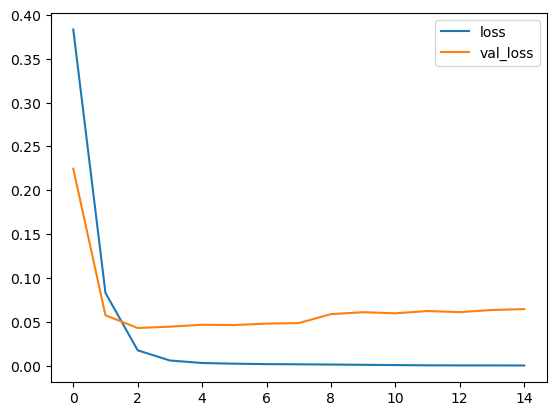

In [33]:
## Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Plot accuracy per iteration

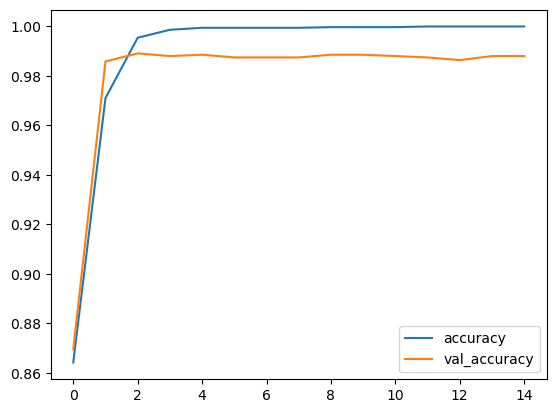

In [34]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## model summary and save

In [35]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 189)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 189, 20)           143300    
                                                                 
 conv1d_6 (Conv1D)           (None, 187, 32)           1952      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 62, 32)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 60, 64)            6208      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 20, 64)           0         
 1D)                                                       

In [36]:
model.save('cnn_spam_classifier.h5')